# Introducción

En este notebook vamos a proceder a introducir algunas de las herramientas (además
del procedimiento estándar que usaremos en los siguientes módulos) para el minado
y análisis de datos sociales. En particular, vamos a trabajar con la marca `Louis Vuitton`,
y las plataformas `Twitter` y `Facebook`.

## Minando Tweets

Para poder trabajar de una forma más efectiva con los notebooks, hemos empaquetado
la funcionalidad vista hasta ahora en clase en un paquete de python pip-instalable
[social-miner](social-miner). Para poder hacer uso de los siguientes comandos, necesitarás
situarte dentro de la carpeta [social-miner](social-miner) desde terminal, y ejecutar:

```shell
> pip install -e .
```

Cuando acabe la instalación, tendrás disponibles los siguientes comandos desde terminal:

- `mine-facebook`
- `mine-tweets`

Para hacer el minado, tál y como está explicado en [README.md](README.md), solo tendrás que
ejecutar los correspondientes comandos seguido de la marca a minar, y estos posts serán
ingeridos en mongoDB.

Asumiendo que estos datos ya han sido minados, y o bien los tenemos en nuestro MongoDB
o nos han sido facilitado en formato *.pickle*, vamos a proceder a leerlos con:

- `load_binary_pickle`

### Leyendo tweets de MongoDB

In [2]:
from social_miner.twitter import read_tweets, dump_tweets
import pandas as pd

Además de los entrypoints de minado, podemos hacer minado de tweets directamente aquí si quisiéramos, mediante los siguientes comandos:

In [3]:
# lv_tweets = read_tweets("LouisVuitton", limit=100)
# len(lv_tweets)

### Leyendo tweets desde Pickle

En lugar de hacer minado, vamos a centrarno en el caso que se nos haya dado los datos en un fichero: `tw_tweets_LouisVuitton.pickle` (por ejemplo, localizado en la carpeta `../tmp`). Para ello, procedemos de la siguiente forma:

In [7]:
from social_miner.commons import load_binary_pickle

lv_tweets = load_binary_pickle(
    filename="../tmp/tw_tweets_LouisVuitton.pickle"
)

len(lv_tweets)

3248

In [8]:
lv_tweets = lv_tweets[0:100]

### Normalización de Tweets

Una vez leídos estos tweets, vamos a proceder al procesado (tál y como se indica en [README](README.md)):

In [9]:
tweets_columns = ["id", "text", "user_metrics", "public_metrics", "created_at"]

tweets_data = [{k: t[k] for k in tweets_columns} for t in lv_tweets]

tweets_df = pd.json_normalize(tweets_data).rename(columns={"id": "tweet_id"})
tweets_df.head(1)

,tweet_id,text,created_at,user_metrics.followers_count,user_metrics.following_count,user_metrics.tweet_count,user_metrics.listed_count,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count
0,1491396464450355207,A mingle of tradition and modernity. Gathered ...,2022-02-09 13:00:00,9263006,5,7045,10151,34,2,626,2


In [10]:
retweeters_columns = ["id", "retweeters"]

retweets_data = [{k: t[k] for k in retweeters_columns} for t in lv_tweets]

retweets_df = pd.DataFrame()

for t in retweets_data:
    r_df = pd.json_normalize(t["retweeters"]).rename(columns={"id": "user_id"})
    columns = list(r_df.columns)
    r_df["tweet_id"] = t["id"]
    r_df = r_df[["tweet_id"]+columns]
    retweets_df = retweets_df.append(r_df)

retweets_df.head(5)

,tweet_id,username,verified,name,user_id,description,public_metrics.followers_count,public_metrics.following_count,public_metrics.tweet_count,public_metrics.listed_count,entities.description.urls,entities.description.hashtags,entities.url.urls,entities.description.mentions,entities.description.cashtags
0,1491396464450355207,TAKISHITAMICHI1,False,MICHIAKI,1113025524597612544,https://t.co/xaItcEcaWf,234,230,1203,1,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,NaN,NaN,NaN
1,1491396464450355207,vlaNascimento,False,@VLN.,1439952679376150534,"Designer ✍:/Comentários (Moda, Beleza,Celebrid...",20,450,821,0,NaN,NaN,NaN,NaN,NaN
2,1491396464450355207,jessy_Annis,False,Jessy Annisa,1474059456434491405,Real estate and sales of medical equipment com...,57,48,167,0,NaN,"[{'start': 105, 'end': 112, 'tag': 'Thanks'}]",NaN,NaN,NaN
3,1491396464450355207,Lylasmom10,False,AnastaciaMarie Combs,205997028,,1919,3643,16535,8,NaN,NaN,NaN,NaN,NaN
4,1491396464450355207,LVMH,True,LVMH,558606074,Official account of the LVMH Group | World lea...,172787,56,16415,1206,NaN,NaN,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,NaN


In [11]:
from social_miner.processing.pipeline import (
    preprocess_and_tokenize,
    extract_hashtags,
    tag_tokens,
    extract_keywords,
    extract_noun_phrases,
    processing_pipeline
)

In [12]:
tweets_df["hashtags"] = tweets_df["text"].apply(
    lambda x: extract_hashtags(x)
)
tweets_df["hashtags"]

0                                        [LouisVuitton]
1                                        [LouisVuitton]
2                                        [LouisVuitton]
3                                [LouisVuitton, LVVolt]
4                                [LouisVuitton, LVVolt]
                            ...                        
95                  [LouisVuitton, BTS, LVMenSS22, Jin]
96                   [LouisVuitton, LVMenSS22, RM, BTS]
97    [V, BTS, LVMenSS22, jhope, SUGA, JungKook, Jim...
98    [V, BTS, LVMenSS22, jhope, SUGA, JungKook, Jim...
99                            [LVTheBook, LouisVuitton]
Name: hashtags, Length: 100, dtype: object

Hay que tener especial cuidado cuando trabajemos con textos internacionales, ya que si no lo pasamos a un idioma común, el análisis podría ser completamente erróneo. Para ello, podemos usar APIs de traducciín (fijando `NEED_TRANSLATION = True`):

In [13]:
NEED_TRANSLATION = False

if NEED_TRANSLATION:
    import googletrans
    tr = googletrans.Translator()

    tweets_df["translated_text"] = tweets_df["text"].apply(
        lambda x: tr.translate(x).text
    )
else:
    tweets_df["translated_text"] = tweets_df["text"]

In [14]:
tweets_df["translated_text"]

0     A mingle of tradition and modernity. Gathered ...
1     A welcoming surprise. In the perfectly manicur...
2     A showcase of creativity and expertise. #Louis...
3     Powerful forms. The #LVVolt Fine Jewelry Colle...
4     Graphic abstractions. The #LVVolt Fine Jewelry...
                            ...                        
95    #Jin in #LouisVuitton. The @bts_twt member and...
96    #RM in #LouisVuitton. The @bts_twt member and ...
97    .@bts_twt in #LouisVuitton. The House Ambassad...
98    .@bts_twt for the January 2022 Special Edition...
99    Play three classic board games that have taken...
Name: translated_text, Length: 100, dtype: object

In [15]:
tweets_df["preprocessed"] = tweets_df["translated_text"].apply(
    lambda x: preprocess_and_tokenize(x, demojize=True)
)
tweets_df["preprocessed"]

0     [a, mingle, of, tradition, and, modernity, gat...
1     [a, welcoming, surprise, in, the, perfectly, m...
2     [a, showcase, of, creativity, and, expertise, ...
3     [powerful, forms, the, lvvolt, fine, jewelry, ...
4     [graphic, abstractions, the, lvvolt, fine, jew...
                            ...                        
95    [jin, in, louisvuitton, the, bts_twt, member, ...
96    [rm, in, louisvuitton, the, bts_twt, member, a...
97    [bts_twt, in, louisvuitton, the, house, ambass...
98    [bts_twt, for, the, january, 2022, special, ed...
99    [play, three, classic, board, games, that, hav...
Name: preprocessed, Length: 100, dtype: object

In [16]:
tweets_df["tagged"] = tweets_df["preprocessed"].apply(
    lambda x: tag_tokens(x)
)
tweets_df["tagged"]

0     [(a, DT), (mingle, NN), (of, IN), (tradition, ...
1     [(a, DT), (welcoming, VBG), (surprise, NN), (i...
2     [(a, DT), (showcase, NN), (of, IN), (creativit...
3     [(powerful, JJ), (forms, NNS), (the, DT), (lvv...
4     [(graphic, JJ), (abstractions, NNS), (the, DT)...
                            ...                        
95    [(jin, NN), (in, IN), (louisvuitton, NN), (the...
96    [(rm, NN), (in, IN), (louisvuitton, NN), (the,...
97    [(bts_twt, NN), (in, IN), (louisvuitton, CC), ...
98    [(bts_twt, NN), (for, IN), (the, DT), (january...
99    [(play, NN), (three, CD), (classic, JJ), (boar...
Name: tagged, Length: 100, dtype: object

In [17]:
tweets_df["keywords"] = tweets_df["tagged"].apply(
    lambda x: extract_keywords(x)
)
tweets_df["keywords"]

0     [mingle, tradition, modernity, majestic, châte...
1     [surprise, gardens, château, voisins, louisvui...
2     [showcase, creativity, expertise, louisvuitton...
3     [powerful, forms, lvvolt, fine, jewelry, colle...
4     [graphic, abstractions, lvvolt, fine, jewelry,...
                            ...                        
95    [jin, louisvuitton, bts_twt, member, house, am...
96    [rm, louisvuitton, bts_twt, member, house, amb...
97    [bts_twt, house, ambassadors, global, supersta...
98    [bts_twt, january, special, editions, voguekor...
99    [play, classic, board, games, maisons, iconic,...
Name: keywords, Length: 100, dtype: object

In [18]:
tweets_df["noun_phrases"] = tweets_df["tagged"].apply(
    lambda x: extract_noun_phrases(x)
)
tweets_df["noun_phrases"]

0     [a mingle, the majestic château, the ingenious...
1            [the château, the extent, the savoirfaire]
2     [a showcase, a collection, the extraordinary s...
3     [the lvvolt fine jewelry, the energy, energeti...
4     [the lvvolt fine jewelry, a universal language...
                            ...                        
95                         [the bts_twt, the lvmenss22]
96                         [the bts_twt, the lvmenss22]
97                           [the house, the lvmenss22]
98                           [the house, the lvmenss22]
99    [classic board, the louisvuitton, the digital ...
Name: noun_phrases, Length: 100, dtype: object

In [19]:
tweets_df.head(5)

,tweet_id,text,created_at,user_metrics.followers_count,user_metrics.following_count,user_metrics.tweet_count,user_metrics.listed_count,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,hashtags,translated_text,preprocessed,tagged,keywords,noun_phrases
0,1491396464450355207,A mingle of tradition and modernity. Gathered ...,2022-02-09 13:00:00,9263006,5,7045,10151,34,2,626,2,[LouisVuitton],A mingle of tradition and modernity. Gathered ...,"[a, mingle, of, tradition, and, modernity, gat...","[(a, DT), (mingle, NN), (of, IN), (tradition, ...","[mingle, tradition, modernity, majestic, châte...","[a mingle, the majestic château, the ingenious..."
1,1491336076128100356,A welcoming surprise. In the perfectly manicur...,2022-02-09 09:00:02,9263006,5,7045,10151,42,1,552,1,[LouisVuitton],A welcoming surprise. In the perfectly manicur...,"[a, welcoming, surprise, in, the, perfectly, m...","[(a, DT), (welcoming, VBG), (surprise, NN), (i...","[surprise, gardens, château, voisins, louisvui...","[the château, the extent, the savoirfaire]"
2,1491071823873671169,A showcase of creativity and expertise. #Louis...,2022-02-08 15:30:00,9263006,5,7045,10151,77,11,1128,2,[LouisVuitton],A showcase of creativity and expertise. #Louis...,"[a, showcase, of, creativity, and, expertise, ...","[(a, DT), (showcase, NN), (of, IN), (creativit...","[showcase, creativity, expertise, louisvuitton...","[a showcase, a collection, the extraordinary s..."
3,1490415013668044809,Powerful forms. The #LVVolt Fine Jewelry Colle...,2022-02-06 20:00:04,9263006,5,7045,10151,93,10,1490,9,"[LouisVuitton, LVVolt]",Powerful forms. The #LVVolt Fine Jewelry Colle...,"[powerful, forms, the, lvvolt, fine, jewelry, ...","[(powerful, JJ), (forms, NNS), (the, DT), (lvv...","[powerful, forms, lvvolt, fine, jewelry, colle...","[the lvvolt fine jewelry, the energy, energeti..."
4,1490233847555973125,Graphic abstractions. The #LVVolt Fine Jewelry...,2022-02-06 08:00:11,9263006,5,7045,10151,71,11,1138,4,"[LouisVuitton, LVVolt]",Graphic abstractions. The #LVVolt Fine Jewelry...,"[graphic, abstractions, the, lvvolt, fine, jew...","[(graphic, JJ), (abstractions, NNS), (the, DT)...","[graphic, abstractions, lvvolt, fine, jewelry,...","[the lvvolt fine jewelry, a universal language..."


### Frecuencia de palabras clave

In [20]:
from social_miner.analysis.text import generate_wordcloud

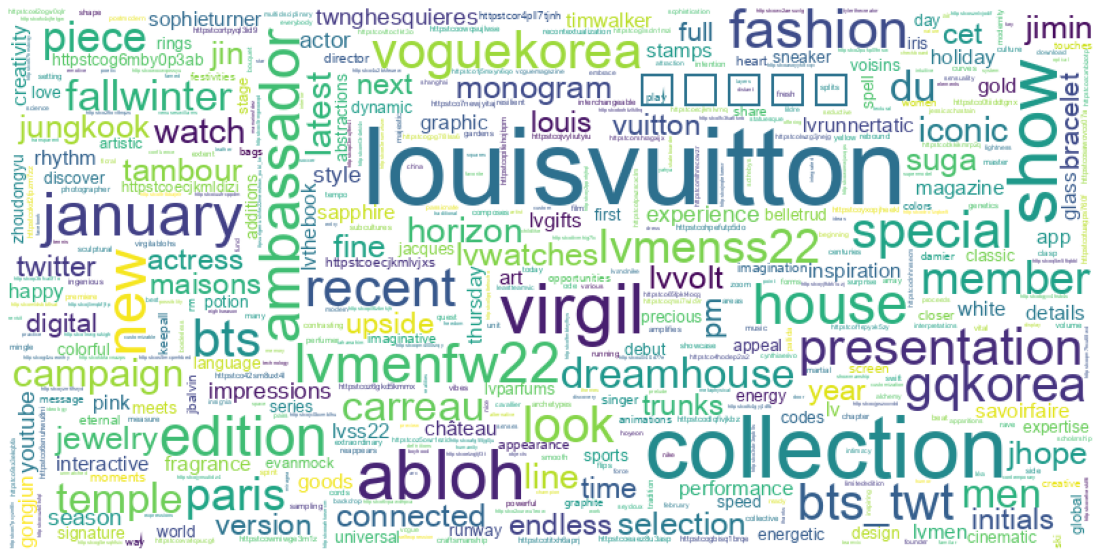

In [21]:
wc = generate_wordcloud(tweets_df, "keywords", collocations=False)

In [22]:
# wc.words_

#### 🤔  Top 20 palabras clave:

In [23]:
from collections import Counter
import pandas as pd

hashtags = list(set(sum(tweets_df["hashtags"].to_list(), [])))

def get_top_freq(df, col, n=20, excluded_words=[]):
    h = Counter()
    for idx, r in df.iterrows():
        h += Counter(r[col])
    data = [{"word": k, "freq": v} for k, v in h.items() if k not in list(excluded_words)]
    wf = pd.DataFrame(data).sort_values(by="freq", ascending=False)
    return wf.head(n)

word_freq = get_top_freq(tweets_df, col="keywords", n=20, excluded_words=hashtags)
word_freq

,word,freq
19,louisvuitton,76
20,collection,47
199,show,33
240,virgil,33
241,abloh,29
222,january,25
35,new,23
208,house,22
205,fashion,21
246,lvmenfw22,21


### Frecuencias de los Hashtags

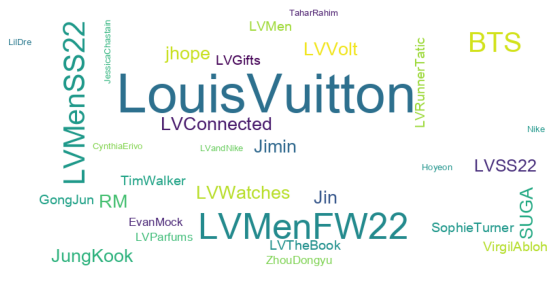

In [24]:
wc = generate_wordcloud(tweets_df, "hashtags", figsize=(10,5))

#### 🤔  Top 20 Hashtags

In [25]:
get_top_freq(tweets_df, col="hashtags", n=20)

,word,freq
0,LouisVuitton,96
15,LVMenFW22,32
4,LVMenSS22,20
24,BTS,18
19,LVConnected,6
1,LVVolt,6
23,V,6
25,jhope,6
26,SUGA,6
27,JungKook,6


### Frases que contienen las palabras clave

In [26]:
from social_miner.analysis.text import get_verbatims

In [27]:
get_verbatims(tweets_df, text_col="text", keyword="Louis", n=5)

['A mingle of tradition and modernity. Gathered at  the majestic Château de Voisins, the ingenious creativity and craftsmanship of #LouisVuitton’s hard-sided trunks are showcased.',
 'A welcoming surprise. In the perfectly manicured gardens of the Château de Voisins, #LouisVuitton’s hard-sided trunks reveal the extent of the savoir-faire that has continued throughout the centuries until today.',
 'A showcase of creativity and expertise. #LouisVuitton presents a collection of trunks in the extraordinary setting of the Château de Voisins near Paris.',
 'Powerful forms. The #LVVolt Fine Jewelry Collection pulsates with the energy of #LouisVuitton’s initials’ energetic shape. Discover the full line including new white and pink gold versions of the Upside Down bracelet at https://t.co/Z6gKD5KMMx https://t.co/SAWOVCO07a',
 'Graphic abstractions. The #LVVolt Fine Jewelry Collection creates a universal language out of #LouisVuitton’s iconic initials. Discover the full line including new white 

### Identificando sintagmas nominales

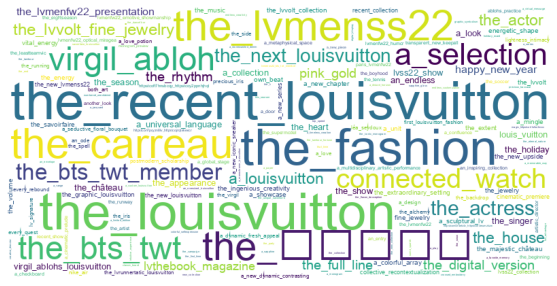

In [28]:
wc = generate_wordcloud(tweets_df, "noun_phrases", figsize=(10,5))


### Detectando tendencias en la serie temporal

In [29]:
tweets_df["created_at"].iloc[0]

Timestamp('2022-02-09 13:00:00')

In [30]:
tweets_ts = tweets_df.set_index(["created_at"])
tweets_ts.head(1)

,tweet_id,text,user_metrics.followers_count,user_metrics.following_count,user_metrics.tweet_count,user_metrics.listed_count,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,hashtags,translated_text,preprocessed,tagged,keywords,noun_phrases
created_at,,,,,,,,,,,,,,,,
2022-02-09 13:00:00,1491396464450355207,A mingle of tradition and modernity. Gathered ...,9263006,5,7045,10151,34,2,626,2,[LouisVuitton],A mingle of tradition and modernity. Gathered ...,"[a, mingle, of, tradition, and, modernity, gat...","[(a, DT), (mingle, NN), (of, IN), (tradition, ...","[mingle, tradition, modernity, majestic, châte...","[a mingle, the majestic château, the ingenious..."


In [31]:
import numpy as np 
metrics_cols = [c for c in list(tweets_df.columns) if "public_metrics" in c]

dt = tweets_ts[metrics_cols].rename(
    columns={
        c: c.replace("public_metrics.", "") for c in metrics_cols
    }
)

dt["n_tweets"] = 1

dt = dt.resample("D").sum().reset_index().rename(
    columns={"created_at": "date"}
)
dt.head(1)

,date,retweet_count,reply_count,like_count,quote_count,n_tweets
0,2021-12-21,107,10,3048,6,1


In [32]:
dt[list(dt.columns)[1:]] += 1

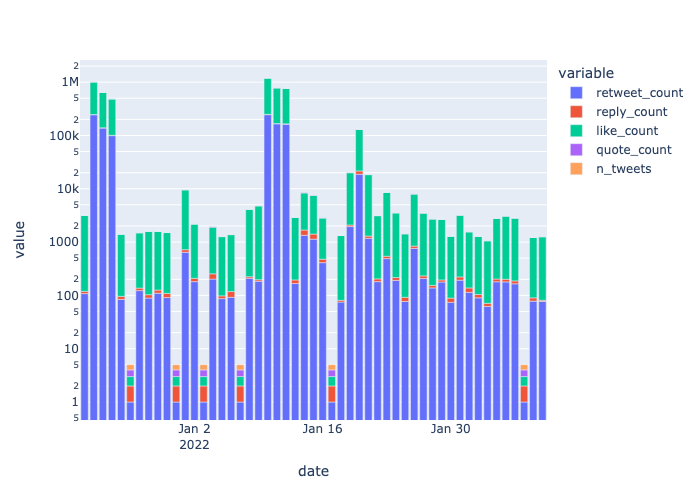

In [33]:
import plotly.express as px

fig = px.bar(
    dt,
    x="date",
    y=list(dt.columns)[1:],
    log_y=True
)

fig.show("png")

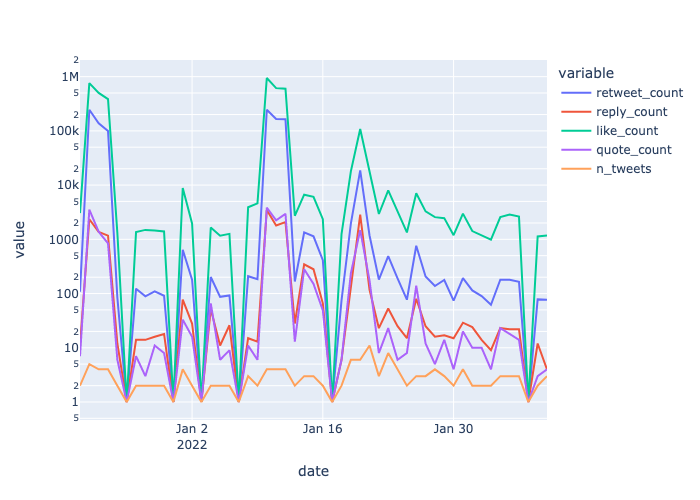

In [34]:
fig = px.line(
    dt,
    x="date",
    y=list(dt.columns)[1:],
    log_y=True
)
fig.show("png")

## Minando posts (y sus comentarios) de Facebook

Al igual que en el caso de los Tweets, podemos proceder a hacer el minado, o si se nos dan los
datos mediante *pickle* podemos proceder a su lectura y procesado de manera inmediata. En este caso, nuevamente, asumiremos que los tenemos almacenados en pickles, aunque dejamos también el código disponible para el caso que queramos leerlos desde MongoDB.

In [42]:
from social_miner.facebook import read_posts, dump_posts

#### Desde MongoDB

In [43]:
lv_posts = read_posts(account="LouisVuitton", limit=100)

#### Desde pickle

In [44]:
lv_posts = load_binary_pickle("../tmp/fb_posts_LouisVuitton.pickle")

In [45]:
len(lv_posts)

2147

In [46]:
lv_posts = posts_lv[0:100]

In [47]:
lv_posts[0].keys()

dict_keys(['_id', 'text', 'post_text', 'shared_text', 'time', 'timestamp', 'image', 'image_lowquality', 'images', 'images_description', 'images_lowquality', 'images_lowquality_description', 'video', 'video_duration_seconds', 'video_height', 'video_id', 'video_quality', 'video_size_MB', 'video_thumbnail', 'video_watches', 'video_width', 'likes', 'comments', 'shares', 'post_url', 'link', 'links', 'user_id', 'username', 'user_url', 'is_live', 'factcheck', 'shared_post_id', 'shared_time', 'shared_user_id', 'shared_username', 'shared_post_url', 'available', 'comments_full', 'reactors', 'w3_fb_url', 'reactions', 'reaction_count', 'with', 'page_id', 'sharers', 'image_id', 'image_ids', 'was_live'])

In [48]:
post_columns = [
    '_id', 'text', 'time', 'images', 'images_description', 
    'video_duration_seconds', 'video_id', 'video_watches', 'likes', 
    'comments', 'shares', 'user_id', 'reactors', 'reactions',
    'reaction_count', 'with', 'page_id', 'sharers', 'image_ids'
]

In [49]:
posts_data = [{k: p[k] for k in post_columns} for p in lv_posts]

In [50]:
import pandas as pd

posts_df = pd.DataFrame(data=posts_data).rename(columns={"_id": "post_id"})
posts_df.head(1)

,post_id,text,time,images,images_description,video_duration_seconds,video_id,video_watches,likes,comments,shares,user_id,reactors,reactions,reaction_count,with,page_id,sharers,image_ids
0,500284724766679,Louis Vuitton presents the Men’s Fall-Winter 2...,2022-01-20 14:59:53,[],[],None,500284724766679,None,32446,1317,1684,215138065124,None,None,None,None,215138065124,None,[]


In [51]:
import logging

comments_cols = ['_id', 'comments_full',]
comments_data = [{k: p[k] for k in comments_cols} for p in lv_posts]


comments_full_cols = [
    "post_id",
    "comment_id",
    "comment_time",
    "comment_text",
    "comment_reactions",
]

comments_df = pd.DataFrame(
    columns=comments_full_cols
)

rows = []
for c in comments_data:
    c_df = pd.DataFrame(c["comments_full"])
    try:
        c_df.loc[:, "post_id"] = c["_id"]
        rows += [c_df[comments_full_cols]]
    except:
        logging.debug(f"Unable to insert: {c['_id']} ({c_df.shape})")
        pass
    
comments_df = pd.concat(rows)
comments_df.head(5)

,post_id,comment_id,comment_time,comment_text,comment_reactions
0,500284724766679,1178018069671515,2022-01-19 12:38:53,"LOVED the masculine and feminine variety, the ...",None
1,500284724766679,1152264291844773,2022-01-19 12:38:53,Fantastic,None
2,500284724766679,500323964762755,2022-01-19 12:38:53,The visuals are awesome,None
3,500284724766679,500326334762518,2022-01-19 12:38:53,Love the creative flow,None
4,500284724766679,440310404421432,2022-01-19 12:38:53,Who is the author of the music? It's absolutel...,None


### Analizando el sentimiento generado con NLT-VADER (Valence Aware Dictionary for Sentiment Reasoning)

In [52]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [53]:
vader_analyzer = SentimentIntensityAnalyzer()

In [54]:
comments_df["sentiment_score"] = comments_df.apply(
    lambda x: vader_analyzer.polarity_scores(x["comment_text"])["compound"], axis=1
)

In [55]:
import numpy as np


def classify_sentiment_score(x):
    if x > 0.5:
        return "clearly positive"
    elif 0.5 >= x and x > 0.05:
        return "positive"
    elif -0.05 >= x and x > -0.5:
        return "negative"
    elif x <= -0.5:
        return "clearly negative"
    else:
        return "neutral"


comments_df["sentiment"] = comments_df["sentiment_score"].apply(
    lambda x: classify_sentiment_score(x)
)


In [56]:
comments_df

,post_id,comment_id,comment_time,comment_text,comment_reactions,sentiment_score,sentiment
0,500284724766679,1178018069671515,2022-01-19 12:38:53,"LOVED the masculine and feminine variety, the ...",None,0.9211,clearly positive
1,500284724766679,1152264291844773,2022-01-19 12:38:53,Fantastic,None,0.5574,clearly positive
2,500284724766679,500323964762755,2022-01-19 12:38:53,The visuals are awesome,None,0.6249,clearly positive
3,500284724766679,500326334762518,2022-01-19 12:38:53,Love the creative flow,None,0.7964,clearly positive
4,500284724766679,440310404421432,2022-01-19 12:38:53,Who is the author of the music? It's absolutel...,None,0.6240,clearly positive
...,...,...,...,...,...,...,...
104,10163089663460125,10163108112565125,2020-02-09 13:35:30,mira Gladys Candia-Laakso,None,0.0000,neutral
105,10163089663460125,10163089668430125,2020-02-09 13:35:30,João Francisco Raposo kaia,None,0.0000,neutral
106,10163089663460125,10163090375855125,2020-02-09 13:35:30,အိုမို😍😍😍,None,0.0000,neutral
107,10163089663460125,10163097451145125,2020-02-09 13:35:30,The girl in the car has an expression on her f...,None,0.3612,positive


### Emojis...

In [57]:
import emoji

comments_df["comment_text_demojized"] = comments_df["comment_text"].apply(
    lambda x: emoji.demojize(x, delimiters=(" ", "")).replace("_", " ")
)

comments_df["sentiment_score_demojized"] = comments_df["comment_text_demojized"].apply(
    lambda x: vader_analyzer.polarity_scores(x)["compound"]
)

comments_df["sentiment_demojized"] = comments_df["sentiment_score_demojized"].apply(
    lambda x: classify_sentiment_score(x)
)


comments_df

,post_id,comment_id,comment_time,comment_text,comment_reactions,sentiment_score,sentiment,comment_text_demojized,sentiment_score_demojized,sentiment_demojized
0,500284724766679,1178018069671515,2022-01-19 12:38:53,"LOVED the masculine and feminine variety, the ...",None,0.9211,clearly positive,"LOVED the masculine and feminine variety, the ...",0.9211,clearly positive
1,500284724766679,1152264291844773,2022-01-19 12:38:53,Fantastic,None,0.5574,clearly positive,Fantastic,0.5574,clearly positive
2,500284724766679,500323964762755,2022-01-19 12:38:53,The visuals are awesome,None,0.6249,clearly positive,The visuals are awesome,0.6249,clearly positive
3,500284724766679,500326334762518,2022-01-19 12:38:53,Love the creative flow,None,0.7964,clearly positive,Love the creative flow,0.7964,clearly positive
4,500284724766679,440310404421432,2022-01-19 12:38:53,Who is the author of the music? It's absolutel...,None,0.6240,clearly positive,Who is the author of the music? It's absolutel...,0.6240,clearly positive
...,...,...,...,...,...,...,...,...,...,...
104,10163089663460125,10163108112565125,2020-02-09 13:35:30,mira Gladys Candia-Laakso,None,0.0000,neutral,mira Gladys Candia-Laakso,0.0000,neutral
105,10163089663460125,10163089668430125,2020-02-09 13:35:30,João Francisco Raposo kaia,None,0.0000,neutral,João Francisco Raposo kaia,0.0000,neutral
106,10163089663460125,10163090375855125,2020-02-09 13:35:30,အိုမို😍😍😍,None,0.0000,neutral,အိုမို smiling face with heart-eyes smiling fa...,0.8402,clearly positive
107,10163089663460125,10163097451145125,2020-02-09 13:35:30,The girl in the car has an expression on her f...,None,0.3612,positive,The girl in the car has an expression on her f...,0.3612,positive


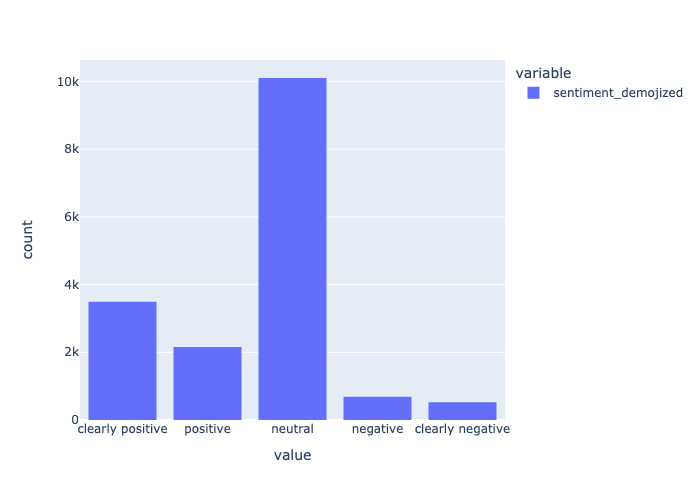

In [58]:
import plotly.express as px
fig = px.histogram(comments_df, x=["sentiment_demojized"])
fig.show("png")

### Analizando sentimientos con Google Cloud Sentiment Analysis API

In [59]:
comments_truncated_df = comments_df[comments_df["post_id"] == "500284724766679"][0:100]
comments_truncated_df["comment_text"]

0     LOVED the masculine and feminine variety, the ...
1                                             Fantastic
2                               The visuals are awesome
3                                Love the creative flow
4     Who is the author of the music? It's absolutel...
                            ...                        
95                                            Que legal
96                                                 Hola
97                                                  面白い
98                                              Beafull
99                                                Hello
Name: comment_text, Length: 100, dtype: object

In [60]:
from social_miner.sentiment.google import GoogleNLApi

analyzer = GoogleNLApi(language="en")

example = analyzer.analyse_sentiment(text=comments_df["comment_text"].values[0])
example

document_sentiment {
  magnitude: 1.600000023841858
  score: 0.800000011920929
}
language: "en"
sentences {
  text {
    content: "LOVED the masculine and feminine variety, the movement, the dreamy feel to the entire show, so well done!"
  }
  sentiment {
    magnitude: 0.8999999761581421
    score: 0.8999999761581421
  }
}
sentences {
  text {
    content: "And had a bit of a laugh at the plague doctor mask ;)"
    begin_offset: 106
  }
  sentiment {
    magnitude: 0.6000000238418579
    score: 0.6000000238418579
  }
}

In [61]:
def get_sentiment(text, post_id):
    r = analyzer.analyse_sentiment(text=text).document_sentiment
    return {"comment_id": post_id, "score_google": r.score, "magnitude_google": r.magnitude}

sentiments = comments_truncated_df.apply(
    lambda x: get_sentiment(x["comment_text_demojized"], x["comment_id"]), axis=1
)

sentiment_df = pd.merge(
    comments_truncated_df,
    pd.json_normalize(sentiments),
    on="comment_id",
    how="left"
)

sentiment_df

,post_id,comment_id,comment_time,comment_text,comment_reactions,sentiment_score,sentiment,comment_text_demojized,sentiment_score_demojized,sentiment_demojized,score_google,magnitude_google
0,500284724766679,1178018069671515,2022-01-19 12:38:53,"LOVED the masculine and feminine variety, the ...",None,0.9211,clearly positive,"LOVED the masculine and feminine variety, the ...",0.9211,clearly positive,0.8,1.6
1,500284724766679,1152264291844773,2022-01-19 12:38:53,Fantastic,None,0.5574,clearly positive,Fantastic,0.5574,clearly positive,0.9,0.9
2,500284724766679,500323964762755,2022-01-19 12:38:53,The visuals are awesome,None,0.6249,clearly positive,The visuals are awesome,0.6249,clearly positive,0.9,0.9
3,500284724766679,500326334762518,2022-01-19 12:38:53,Love the creative flow,None,0.7964,clearly positive,Love the creative flow,0.7964,clearly positive,0.9,0.9
4,500284724766679,440310404421432,2022-01-19 12:38:53,Who is the author of the music? It's absolutel...,None,0.6240,clearly positive,Who is the author of the music? It's absolutel...,0.6240,clearly positive,0.4,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...
95,500284724766679,500332944761857,2022-01-19 12:39:02,Que legal,None,0.1280,positive,Que legal,0.1280,positive,0.9,0.9
96,500284724766679,500318964763255,2022-01-19 12:39:02,Hola,None,0.0000,neutral,Hola,0.0000,neutral,0.3,0.3
97,500284724766679,500337454761406,2022-01-19 12:39:02,面白い,None,0.0000,neutral,面白い,0.0000,neutral,0.9,0.9
98,500284724766679,500331548095330,2022-01-19 12:39:02,Beafull,None,0.0000,neutral,Beafull,0.0000,neutral,0.3,0.3


In [62]:
sentiment_df["sentiment_google"] = sentiment_df["score_google"].apply(lambda x: classify_sentiment_score(x))

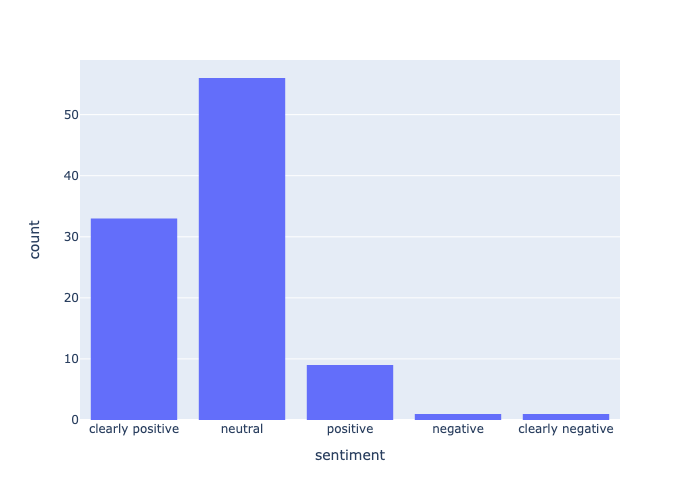

In [63]:
import plotly.express as px

fig = px.histogram(sentiment_df, x="sentiment",)
fig.show("png")